# 1. Import / Clean Dataset

In [88]:
# pip install dccp

In [89]:
# pip install cvxpy

In [90]:
import pandas as pd
import numpy as np
import numpy.core.multiarray
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction

import dccp
from dccp.problem import is_dccp
import cvxpy as cvx

import pickle
import scipy.optimize as optim

import traceback
import math
import copy
import time
import os,sys
from collections import defaultdict
from random import seed, shuffle
from collections import defaultdict
from copy import deepcopy

In [91]:
import warnings
warnings.filterwarnings("ignore")

In [92]:
start_time = time.time()

In [93]:
df = pd.read_csv('compas-scores-two-years.csv')
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [94]:
# Feature selection: we add jail time
df['jail_time']=(df['c_jail_out'].apply(pd.to_datetime) - df['c_jail_in'].apply(pd.to_datetime)).dt.days

In [95]:
feauture_name = ['age', "race", "sex", "priors_count", "c_charge_degree","jail_time","decile_score", 'score_text', 'two_year_recid']

df_new = df[feauture_name]
df_clean = df_new[(df['race'] == 'African-American') | (df['race'] == 'Caucasian')]
df_clean.head()


,age,race,sex,priors_count,c_charge_degree,jail_time,decile_score,score_text,two_year_recid
1,34,African-American,Male,0,F,10.0,3,Low,1
2,24,African-American,Male,4,F,1.0,4,Low,1
3,23,African-American,Male,1,F,NaN,8,High,0
6,41,Caucasian,Male,14,F,6.0,6,Medium,1
8,39,Caucasian,Female,0,M,2.0,1,Low,0


In [96]:
df_clean.dropna(inplace = True)

In [97]:
df_clean.head()

,age,race,sex,priors_count,c_charge_degree,jail_time,decile_score,score_text,two_year_recid
1,34,African-American,Male,0,F,10.0,3,Low,1
2,24,African-American,Male,4,F,1.0,4,Low,1
6,41,Caucasian,Male,14,F,6.0,6,Medium,1
8,39,Caucasian,Female,0,M,2.0,1,Low,0
9,21,Caucasian,Male,1,F,0.0,3,Low,1


In [98]:
X = df_clean[['age', "race", "sex", "priors_count", "c_charge_degree","jail_time","decile_score", 'score_text']]
y = df_clean['two_year_recid']

## Algorithm 1: Fairness Constraints: Mechanisms for Fair Classification (Yanzhao & Lei)

## Algorithm 2: Fairness Beyond Disparate Treatment & Disparate Impact: Learning Classification without Disparate Mistreatment (Hongxu & Zhengfei)

#### Preprocessing for train data

In [99]:
intercept = np.ones(X.shape[0]).reshape(X.shape[0], 1)
X['intercept'] = intercept
column_to_move = 'intercept'
new_order = [column_to_move] + [col for col in X.columns if col != column_to_move]
X = X[new_order]
X.head()

,intercept,age,race,sex,priors_count,c_charge_degree,jail_time,decile_score,score_text
1,1.0,34,African-American,Male,0,F,10.0,3,Low
2,1.0,24,African-American,Male,4,F,1.0,4,Low
6,1.0,41,Caucasian,Male,14,F,6.0,6,Medium
8,1.0,39,Caucasian,Female,0,M,2.0,1,Low
9,1.0,21,Caucasian,Male,1,F,0.0,3,Low


In [100]:
## Use standardized transformation for 'priors_count' and 'jail_time'
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X['priors_count'] = scaler.fit_transform(X[['priors_count']])
X['jail_time'] = scaler.fit_transform(X[['jail_time']])
X['age'] = scaler.fit_transform(X[['age']])

In [101]:
## transform the race, sex, c_charge_degree, score_text, using label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X['race'] = le.fit_transform(X['race'])
X['sex'] = le.fit_transform(X['sex'])
X['c_charge_degree'] = le.fit_transform(X['c_charge_degree'])

label_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
X['score_text'] = X['score_text'].map(label_mapping)

In [102]:
X.reset_index(inplace = True)

In [103]:
## Use one hot encoder for 'decile_score'
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse = False)
encoded_data = encoder.fit_transform(X[['decile_score']])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['decile_score']))


In [104]:
X = pd.concat([X, encoded_df], axis=1)

In [105]:
X.drop(columns = ['decile_score'], inplace = True)
X.head()

,index,intercept,age,race,sex,priors_count,c_charge_degree,jail_time,score_text,decile_score_1,decile_score_2,decile_score_3,decile_score_4,decile_score_5,decile_score_6,decile_score_7,decile_score_8,decile_score_9,decile_score_10
0,1,1.0,-0.048742,0,1,-0.733669,0,-0.167787,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1.0,-0.894973,0,1,0.055933,0,-0.340683,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,1.0,0.543619,1,1,2.029939,0,-0.244630,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,8,1.0,0.374373,1,0,-0.733669,1,-0.321473,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9,1.0,-1.148842,1,1,-0.536269,0,-0.359894,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


For race: 0 represents African-American, 1 reprensents Caucasian

In [106]:
y = y.reset_index(drop = True)

In [107]:
y = 2 * y - 1
y

0       1
1       1
2       1
3      -1
4       1
       ..
5910    1
5911   -1
5912   -1
5913   -1
5914   -1
Name: two_year_recid, Length: 5915, dtype: int64

#### Train_test_split

In [108]:
from sklearn.model_selection import train_test_split

features = ["age", "race", "sex", "priors_count", "c_charge_degree","jail_time", "score_text", "decile_score"]
continuous_feature = ["priors_count"]
sensi_attr = ["race"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1,shuffle=True)
x_train_control=x_train[sensi_attr]
x_test_control =x_test[sensi_attr]
feature_names= x_train.columns

#converting to array
x_train,x_test, = x_train.values,x_test.values
y_train, y_test = y_train.values, y_test.values
x_train_control,x_test_control = x_train_control.values, x_test_control.values

# convert control group to index
x_train_control={sensi_attr[0]:x_train_control.flatten()}
x_test_control={sensi_attr[0]:x_test_control.flatten()}


In [109]:
idx = (np.array(X.index),)

#### Algorithm

In [110]:
def problem(constraint_params, loss, constraints):
      if constraint_params is not None:
        # By default it will be true
        if constraint_params.get("take_initial_sol") is None:
            initial_solution = True
        elif constraint_params["take_initial_sol"] == False:
            initial_solution = False

        if initial_solution == True:
            p = cvx.Problem(cvx.Minimize(loss), [])
            p.solve()
        # Minimize the loss with the set constraints
        return cvx.Problem(cvx.Minimize(loss), constraints)

In [111]:
# Set a random seed firstly
np.random.seed(0)

def train_model(x, y, x_control, EPS, constraint_params,tau, mu):
    max_iters = 100
    max_iter_dccp = 50
    num_point, num_features = x.shape
    weight = cvx.Variable(num_features)
    weight.value = np.random.rand(x.shape[1])
    loss = cvx.sum(cvx.logistic(cvx.multiply(-y, x*weight))) / num_point # Using Logistic Classifier

    constraints = []
    if constraint_params is not None:

        for i in constraint_params["sensi_cov_thresh"].keys():

            attribute_list = x_train_control[i]

            total_s_val = {param:{} for param in [0,1,2]}
            avg_s_val = {param:{} for param in [0,1,2]}
            constr_sum = {param:{} for param in [0,1,2]}

            for v in set(attribute_list):
                total_s_val[0][v] = sum(x_train_control[i] == v)
                # when y equal to -1
                total_s_val[1][v] = np.sum((x_train_control[i] == v) & (y_train == -1))
                # when y equal to +1
                total_s_val[2][v] = np.sum((x_train_control[i] == v) & (y_train == +1))

            for a in [0,1,2]:

                avg_s_val[a][0] = total_s_val[a][1] / float(total_s_val[a][0] + total_s_val[a][1])
                avg_s_val[a][1] = 1.0 - avg_s_val[a][0]

            for x in set(attribute_list):
                idx = x_train_control[i] == x
                # #DCCP constraints
                dist_bound_prod = cvx.multiply(y_train[idx], x_train[idx] * weight)

                # Avg misclassification distance from boundary
                constr_sum[0][x] = cvx.sum(cvx.minimum(0, dist_bound_prod)) * (avg_s_val[0][x] / len(x_train))
                # Avg FP distance from boundary (only operates on the ground truth neg dataset)
                constr_sum[1][x] = cvx.sum(cvx.minimum(0, cvx.multiply((1 - y_train[idx])/2.0, dist_bound_prod))) * (avg_s_val[1][x] / sum(y_train == -1))
                # avg FN distance from boundary
                constr_sum[2][x] = cvx.sum(cvx.minimum(0, cvx.multiply((1 + y_train[idx])/2.0, dist_bound_prod))) * (avg_s_val[2][x] / sum(y_train == +1))

            if constraint_params["constraint_num"] == 4:
                params = [1,2]
            elif constraint_params["constraint_num"] in [0,1,2]:
                params = [constraint_params["constraint_num"]]

            for p in params:
                threshold = abs(constraint_params["sensi_cov_thresh"][i][p][1] - constraint_params["sensi_cov_thresh"][i][p][0])
                constraints.append(constr_sum[p][1] <= constr_sum[p][0] + threshold)
                constraints.append(constr_sum[p][1] >= constr_sum[p][0] - threshold)


            prob = problem(constraint_params, loss, constraints)
    try:
      prob.solve(method='dccp', tau=tau, mu=mu, tau_max=1e10,
                 solver='ECOS', verbose=False, feastol=EPS, abstol=EPS,
                 reltol=EPS,feastol_inacc=EPS, abstol_inacc=EPS, reltol_inacc=EPS,
                 max_iters=max_iters, max_iter=max_iter_dccp)
    except:
      traceback.print_exc()
      sys.stdout.flush()
      sys.exit(1)

    # check that the fairness constraint is satisfied
    for fairness_const in constraints:
        pass

    return np.array(weight.value).flatten() # flatten converts it to a 1d array



In [112]:
def classification_dictionary(vals, y_true, y_pred, classification_dict):

  for s in set(vals):
        classification_dict[s] = {}
        y_true_local = y_true[vals==s]
        y_pred_local = y_pred[vals==s]

        # store false_positive and false_negative we will use further
        false_positive = np.sum((y_true_local == -1.0) & (y_pred_local == +1.0))
        classification_dict[s]["fp"] = false_positive
        false_negative = np.sum((y_true_local == +1.0) & (y_pred_local == -1.0))
        classification_dict[s]["fn"] = false_negative

        true_positive = np.sum((y_true_local == +1.0) & (y_pred_local == +1.0))
        true_negative = np.sum((y_true_local == -1.0) & (y_pred_local == -1.0))

        false_positive_rate = float(false_positive) / float(false_positive + true_negative)
        classification_dict[s]["fpr"] = false_positive_rate

        false_negative_rate = float(false_negative) / float(false_negative + true_positive)
        classification_dict[s]["fnr"] = false_negative_rate

        true_positive_rate = float(true_positive) / float(true_positive + false_negative)
        classification_dict[s]["tpr"] = true_positive_rate
        true_negative_rate = float(true_negative) / float(true_negative + false_positive)
        classification_dict[s]["tnr"] = true_negative_rate
        classification_dict[s]["acc"] = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

  return classification_dict


In [113]:
def sensitive_race(y_true, y_pred, x_control, sensitive_attributes, flag ):

    x_internal_control = deepcopy(x_control)
    classification_dict = {}
    sense = sensitive_attributes[0]
    vals = x_internal_control[sense]
    return classification_dictionary(vals, y_true, y_pred, classification_dict)

In [114]:
def compute_acc(x_train, y_train, x_test, y_test, y_train_predicted, y_test_predicted):
     # compute train acc
    correct_train = np.equal(y_train_predicted, y_train).astype(int)
    train_score = float(sum(correct_train)) / float(len(correct_train))
    correct_train = sum(correct_train)
     #compute test acc
    correct_test = np.equal(y_test_predicted, y_test).astype(int)
    test_score = float(sum(correct_test)) / float(len(correct_test))
    correct_test = sum(correct_test)

    return train_score, test_score, correct_train, correct_test

In [115]:
def dist_boundary(w, x, s_attr_arr):
    if isinstance(w, dict):
        distances_boundary = np.array([np.dot(x[i], w.get(s_attr_arr[i], 0)) for i in range(len(x))])
    else:
        distances_boundary = np.dot(x, w)
    return distances_boundary


In [116]:
def classification_stats(w, x_train, y_train, x_train_control, x_test, y_test, x_test_control, sensi_attr):
    sense = sensi_attr[0]

    dist_boundary_train = dist_boundary(w, x_train, x_train_control[sense])
    dist_boundary_test = dist_boundary(w, x_test, x_test_control[sense])

    labels_assigned_train = np.sign(dist_boundary_train)
    labels_assigned_test = np.sign(dist_boundary_test)

    train_score, test_score, correct_train, correct_test = compute_acc(x_train, y_train, x_test, y_test, labels_assigned_train, labels_assigned_test)

    train_classification_dict = sensitive_race(y_train, labels_assigned_train, x_train_control, sensi_attr, False)
    test_classification_dict = sensitive_race(y_test, labels_assigned_test, x_test_control, sensi_attr, True)

    return train_score, test_score, train_classification_dict, test_classification_dict

In [117]:
def classifier(EPS,tau,mu,constraint_params):

    w = train_model(x_train, y_train, x_train_control, EPS, constraint_params,tau, mu)
    train_score, test_score, train_classification_dict, test_classification_dict = classification_stats(w, x_train, y_train, x_train_control, x_test, y_test, x_test_control, sensi_attr)

    return w, test_score, test_classification_dict


In [118]:
# Compute accuracy with no constraint
def accuracy_nocons(threshold, flag):
    cons_num = 0
    sensi_cov_thresh = {"race": {0:{0:0, 1:threshold}, 1:{0:0, 1:0}, 2:{0:0, 1:0}}}
    constraint_params = {"constraint_num": cons_num, "tau": tau, "mu": mu, "sensi_cov_thresh": sensi_cov_thresh}
    w_uncons, acc_cons, classification_dict = classifier(EPS,tau,mu,constraint_params)
    if flag == True:
        print("Unconstrained classifier")
        print("Accuracy:  " + str(round(acc_cons,5)))
        print("s   FPR.  FNR.  TNR.  TPR. Accuracy")
        for key in classification_dict:
            print("-----------------------------------------")
            print(str(key) + "   " + str(round(classification_dict[key]['fpr'],2)) + "  " +str(round(classification_dict[key]['fnr'],2))
            + "   " +str(round(classification_dict[key]['tnr'],2))+
              "  " +str(round(classification_dict[key]['tpr'],2))+ "   "+ str(classification_dict[key]['acc']))

        print()

    return (acc_cons, abs(classification_dict[0]['fpr']-classification_dict[1]['fpr']) ,
    abs(classification_dict[0]['fnr']-classification_dict[1]['fnr']),classification_dict[0]['acc'],classification_dict[1]['acc'])


In [119]:
# Compute accuracy with FPR to be constraint
def accuracy_FPR(threshold, flag):
    cons_num = 1
    sensi_cov_thresh = {"race": {0:{0:0, 1:0}, 1:{0:0, 1:threshold}, 2:{0:0, 1:0}}}
    constraint_params = {"constraint_num": cons_num, "tau": tau, "mu": mu, "sensi_cov_thresh": sensi_cov_thresh}
    w_cons, acc_cons, classification_dict  = classifier(EPS,tau,mu,constraint_params)
    if flag == True:
        print("FPR constraint classifier")
        print("Accuracy:  " + str(round(acc_cons,4)))
        print("s   FPR.  FNR.  TNR.  TPR. Accuracy")
        for key in classification_dict:
            print("-----------------------------------------")
            print(str(key) + "   " + str(round(classification_dict[key]['fpr'],2)) + "  " +str(round(classification_dict[key]['fnr'],2)) + "  " +str(round(classification_dict[key]['tnr'],2))+
                  "  " +str(round(classification_dict[key]['tpr'],2)) + "  "+ str(classification_dict[key]['acc']))
        print()

    return (acc_cons, abs(classification_dict[0]['fpr']-classification_dict[1]['fpr']) ,
    abs(classification_dict[0]['fnr']-classification_dict[1]['fnr']),classification_dict[0]['acc'],classification_dict[1]['acc'])


In [120]:
# Compute accuracy with FNR to be constraint
def accuracy_FNR(threshold, flag):
    cons_num = 2
    sensi_cov_thresh = {"race": {0:{0:0, 1:0}, 1:{0:0, 1:0}, 2:{0:0, 1:threshold}}}
    constraint_params = {"constraint_num": cons_num, "tau": tau, "mu": mu, "sensi_cov_thresh": sensi_cov_thresh}
    w_cons, acc_cons, classification_dict  = classifier(EPS,tau,mu,constraint_params)
    if flag == True:
        print("FNR constraint classifier")
        print("Accuracy:  " + str(round(acc_cons,4)))
        print("s   FPR.  FNR.  TNR.  TPR. Accuracy")
        for key in classification_dict:
            print("-----------------------------------------")
            print(str(key) + "   " + str(round(classification_dict[key]['fpr'],2)) + "  " +str(round(classification_dict[key]['fnr'],2)) + "  " +str(round(classification_dict[key]['tnr'],2))+
              "  " +str(round(classification_dict[key]['tpr'],2))+ " "+ str(classification_dict[key]['acc']))

            print()

    return (acc_cons, abs(classification_dict[0]['fpr']-classification_dict[1]['fpr']) ,
    abs(classification_dict[0]['fnr']-classification_dict[1]['fnr']),classification_dict[0]['acc'],classification_dict[1]['acc'])


In [121]:
# Compute accuracy with FPR & FNR to be constraint
def accuracy_FPR_FNR(threshold, flag):
    cons_num = 4
    sensi_cov_thresh = {"race": {0:{0:0, 1:0}, 1:{0:0, 1:threshold}, 2:{0:0, 1:threshold}}}
    constraint_params = {"constraint_num": cons_num, "tau": tau, "mu": mu, "sensi_cov_thresh": sensi_cov_thresh}
    w_cons, acc_cons, classification_dict  = classifier(EPS,tau,mu, constraint_params)
    if flag == True:
        print("FPR & FNR constraint classifier")
        print("Accuracy:  " + str(round(acc_cons,4)))
        print("s   FPR.  FNR.  TNR.  TPR. Accuracy")
        for key in classification_dict:
            print("--------------------------------------------------")
            print(str(key) + "   " + str(round(classification_dict[key]['fpr'],2)) + "  " +str(round(classification_dict[key]['fnr'],2)) + "  " +str(round(classification_dict[key]['tnr'],2))+
              "  " +str(round(classification_dict[key]['tpr'],2))+ " "+ str(classification_dict[key]['acc']))

            print()

    return (acc_cons, abs(classification_dict[0]['fpr']-classification_dict[1]['fpr']) ,
    abs(classification_dict[0]['fnr']- classification_dict[1]['fnr']),classification_dict[0]['acc'],classification_dict [1]['acc'])


In [122]:
tau = 3.0
mu = 1.5
EPS = 1e-6

In [123]:
threshold = 0
print("Threshold is " + str(threshold))
print("-----------------------------------------------------------------------------------------------")
print()
acc_cons, diff_fpr, diff_fnr,acc_w,acc_b = accuracy_nocons(threshold, True)
acc_cons, diff_fpr, diff_fnr,acc_w,acc_b = accuracy_FPR(threshold, True)
acc_cons, diff_fpr, diff_fnr,acc_w,acc_b = accuracy_FNR(threshold, True)
acc_cons, diff_fpr, diff_fnr,acc_w,acc_b = accuracy_FPR_FNR(threshold, True)
print()

Threshold is 0
-----------------------------------------------------------------------------------------------

Unconstrained classifier
Accuracy:  0.69236
s   FPR.  FNR.  TNR.  TPR. Accuracy
-----------------------------------------
0   0.33  0.3   0.67  0.7   0.6864924958310172
-----------------------------------------
1   0.21  0.45   0.79  0.55   0.7014667817083693

FPR constraint classifier
Accuracy:  0.6765
s   FPR.  FNR.  TNR.  TPR. Accuracy
-----------------------------------------
0   0.26  0.36  0.74  0.64  0.688715953307393
-----------------------------------------
1   0.33  0.36  0.67  0.64  0.6574633304572908

FNR constraint classifier
Accuracy:  0.6836
s   FPR.  FNR.  TNR.  TPR. Accuracy
-----------------------------------------
0   0.26  0.36  0.74  0.64 0.6826014452473597

-----------------------------------------
1   0.26  0.41  0.74  0.59 0.6850733390854185

FPR & FNR constraint classifier
Accuracy:  0.6792
s   FPR.  FNR.  TNR.  TPR. Accuracy
-------------------------

In [124]:
end_time = time.time()
runtime_time = (end_time-start_time)
print("Runtime of the whole process is " + str(runtime_time) + ' seconds')

Runtime of the whole process is 33.63297891616821 seconds


## Analysis in c value

In [125]:
diff_fpr_dictionary_nocons = {}
diff_fpr_dictionary_FPR = {}
diff_fpr_dictionary_FNR = {}
diff_fpr_dictionary_FPR_FNR = {}

diff_fnr_dictionary_nocons = {}
diff_fnr_dictionary_FPR = {}
diff_fnr_dictionary_FNR = {}
diff_fnr_dictionary_FPR_FNR = {}

acc_dictionary_nocons = {}
acc_dictionary_FPR = {}
acc_dictionary_FNR = {}
acc_dictionary_FPR_FNR = {}

for threshold in range(0, 50, 5):
    threshold = threshold/1000

    acc_cons, diff_fpr, diff_fnr,acc_w,acc_b = accuracy_nocons(threshold, True)
    diff_fpr_dictionary_nocons[threshold] = diff_fpr
    diff_fnr_dictionary_nocons[threshold] = diff_fnr
    acc_dictionary_nocons[threshold] = acc_cons

    acc_cons, diff_fpr, diff_fnr,acc_w,acc_b = accuracy_FPR(threshold, True)
    diff_fpr_dictionary_FPR[threshold] = diff_fpr
    diff_fnr_dictionary_FPR[threshold] = diff_fnr
    acc_dictionary_FPR[threshold] = acc_cons

    acc_cons, diff_fpr, diff_fnr,acc_w,acc_b = accuracy_FNR(threshold, True)
    diff_fpr_dictionary_FNR[threshold] = diff_fpr
    diff_fnr_dictionary_FNR[threshold] = diff_fnr
    acc_dictionary_FNR[threshold] = acc_cons

    acc_cons, diff_fpr, diff_fnr,acc_w,acc_b = accuracy_FPR_FNR(threshold, True)
    diff_fpr_dictionary_FPR_FNR[threshold] = diff_fpr
    diff_fnr_dictionary_FPR_FNR[threshold] = diff_fnr
    acc_dictionary_FPR_FNR[threshold] = acc_cons


Unconstrained classifier
Accuracy:  0.69236
s   FPR.  FNR.  TNR.  TPR. Accuracy
-----------------------------------------
0   0.33  0.3   0.67  0.7   0.6864924958310172
-----------------------------------------
1   0.21  0.45   0.79  0.55   0.7014667817083693

FPR constraint classifier
Accuracy:  0.6765
s   FPR.  FNR.  TNR.  TPR. Accuracy
-----------------------------------------
0   0.26  0.36  0.74  0.64  0.688715953307393
-----------------------------------------
1   0.33  0.36  0.67  0.64  0.6574633304572908

FNR constraint classifier
Accuracy:  0.6836
s   FPR.  FNR.  TNR.  TPR. Accuracy
-----------------------------------------
0   0.26  0.36  0.74  0.64 0.6826014452473597

-----------------------------------------
1   0.26  0.41  0.74  0.59 0.6850733390854185

FPR & FNR constraint classifier
Accuracy:  0.6792
s   FPR.  FNR.  TNR.  TPR. Accuracy
--------------------------------------------------
0   0.24  0.37  0.76  0.63 0.6903835464146748

---------------------------------------

## Plot of C value

### For the FPR constraint

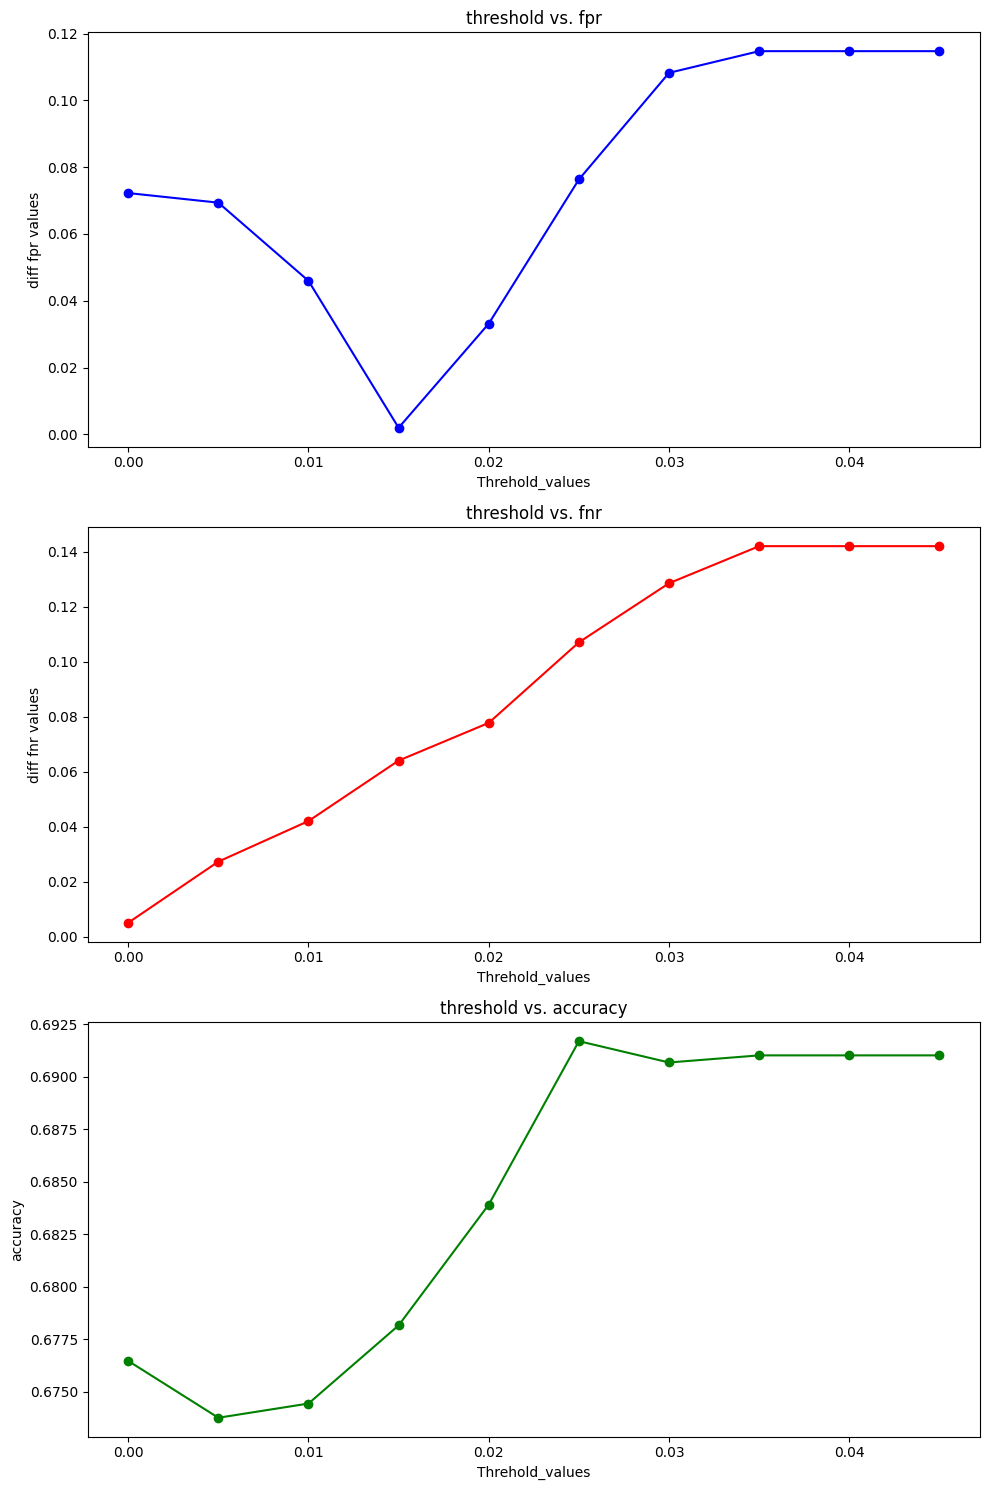

In [126]:
# For the FPR constraint
threshold_values = list(diff_fpr_dictionary_FPR.keys())
diff_fpr_values = list(diff_fpr_dictionary_FPR.values())
diff_fnr_values = list(diff_fnr_dictionary_FPR.values())
acc_values = list(acc_dictionary_FPR.values())

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot data on subplots
axs[0].plot(threshold_values, diff_fpr_values, marker='o', linestyle='-', color='b')
axs[0].set_title('threshold vs. fpr')
axs[0].set_xlabel('Threhold_values')
axs[0].set_ylabel('diff fpr values')

axs[1].plot(threshold_values, diff_fnr_values, marker='o', linestyle='-', color='r')
axs[1].set_title('threshold vs. fnr')
axs[1].set_xlabel('Threhold_values')
axs[1].set_ylabel('diff fnr values')

axs[2].plot(threshold_values, acc_values, marker='o', linestyle='-', color='g')
axs[2].set_title('threshold vs. accuracy')
axs[2].set_xlabel('Threhold_values')
axs[2].set_ylabel('accuracy')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


Here we observe that as the unfairness threshold rises, the accuracy also increases. With the increase in unfairness, the false positive rate (FPR) will decrease from 0 to 0.015, and then decrease; while false negative rate (FNR) will increase from begining to end.

### For the FNR constraint

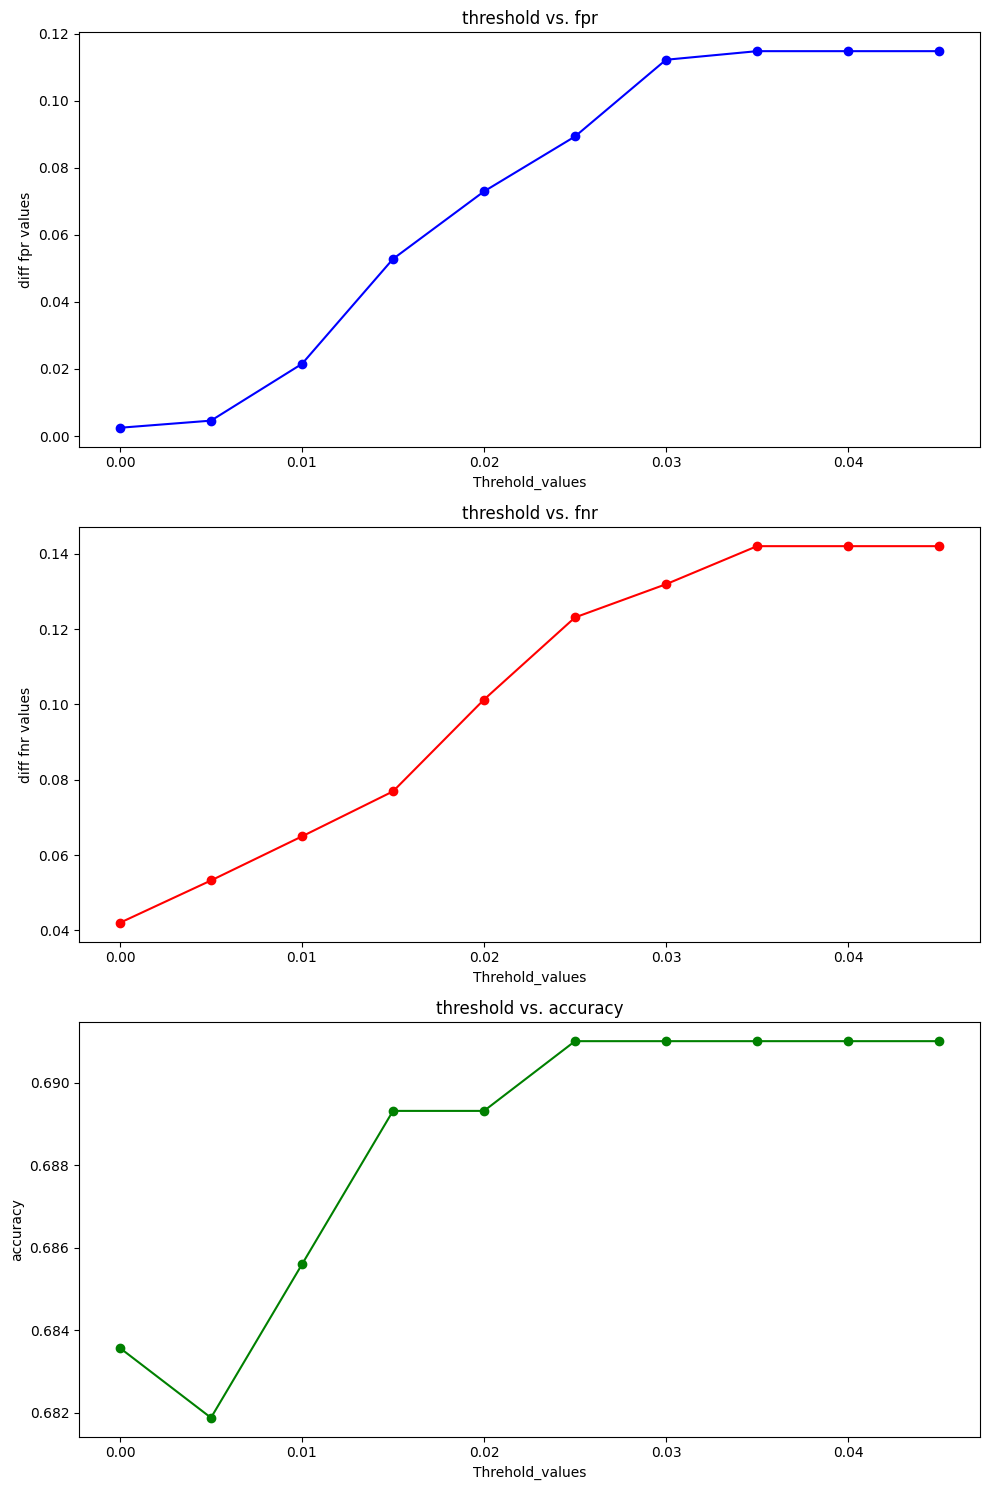

In [127]:
# For the FNR constraint
threshold_values = list(diff_fpr_dictionary_FNR.keys())
diff_fpr_values = list(diff_fpr_dictionary_FNR.values())
diff_fnr_values = list(diff_fnr_dictionary_FNR.values())
acc_values = list(acc_dictionary_FNR.values())

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot data on subplots
axs[0].plot(threshold_values, diff_fpr_values, marker='o', linestyle='-', color='b')
axs[0].set_title('threshold vs. fpr')
axs[0].set_xlabel('Threhold_values')
axs[0].set_ylabel('diff fpr values')

axs[1].plot(threshold_values, diff_fnr_values, marker='o', linestyle='-', color='r')
axs[1].set_title('threshold vs. fnr')
axs[1].set_xlabel('Threhold_values')
axs[1].set_ylabel('diff fnr values')

axs[2].plot(threshold_values, acc_values, marker='o', linestyle='-', color='g')
axs[2].set_title('threshold vs. accuracy')
axs[2].set_xlabel('Threhold_values')
axs[2].set_ylabel('accuracy')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

Here we see the accuracy will decrease firstly, and when the threshold value reaches about 0.05, it will begin to increase fastly, and when the threshold reached 0.025, it will stop to increase. And with the threshold value increasing, both the False positive rate and the False negative rate begin to increase

### For the FNR & FPR constraint

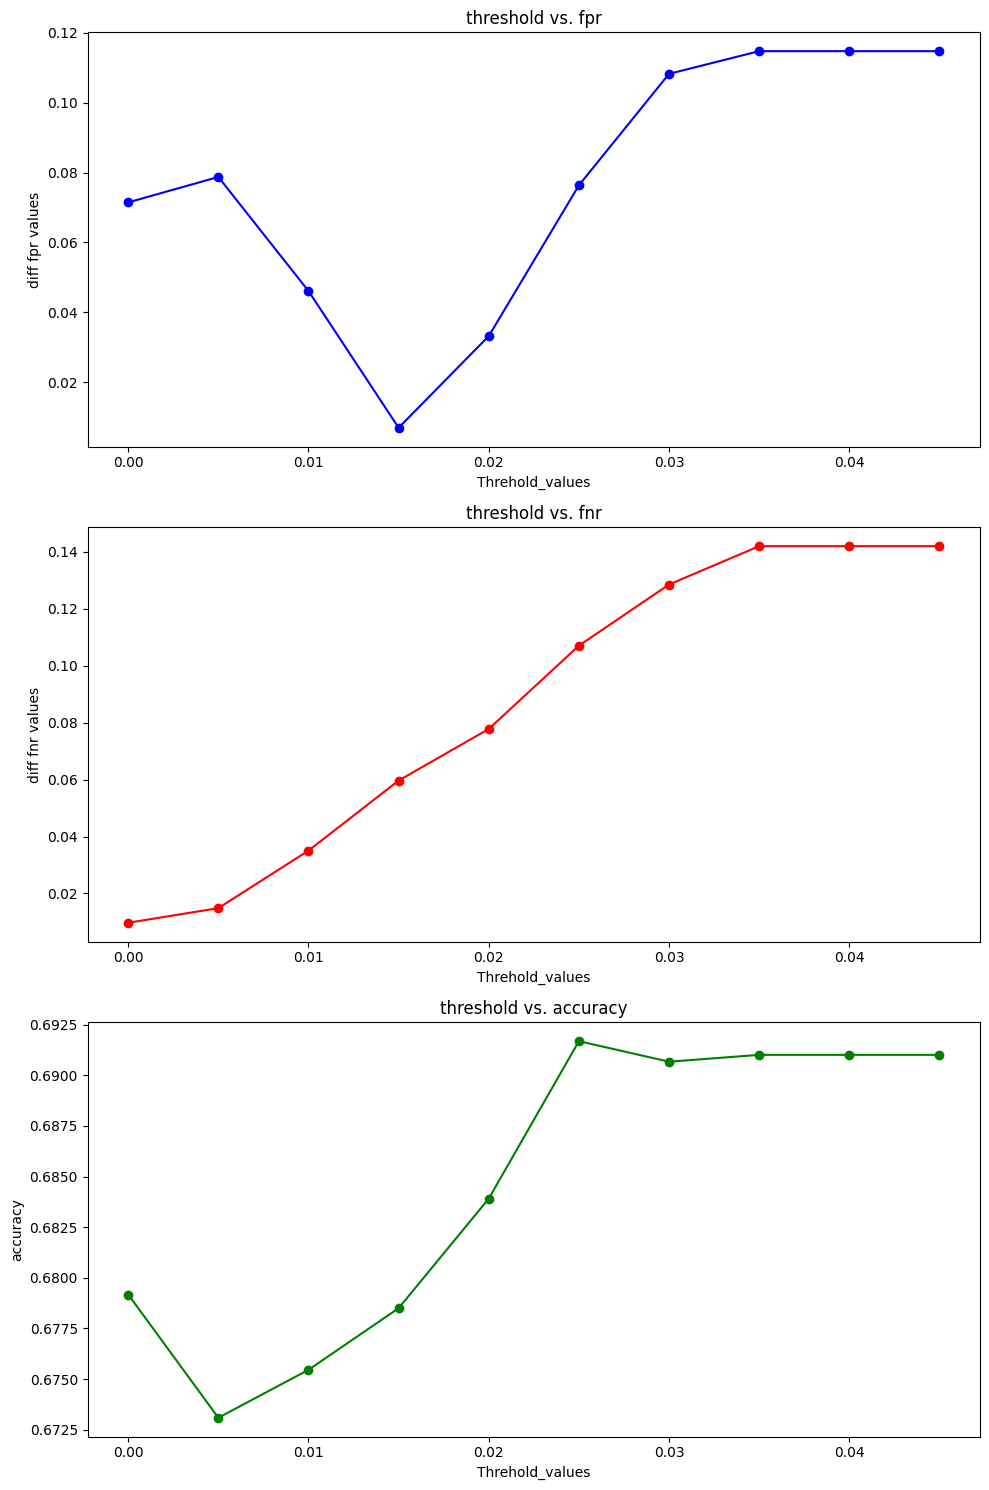

In [128]:
# For the FNR and FPR constraint
threshold_values = list(diff_fpr_dictionary_FPR_FNR.keys())
diff_fpr_values = list(diff_fpr_dictionary_FPR_FNR.values())
diff_fnr_values = list(diff_fnr_dictionary_FPR_FNR.values())
acc_values = list(acc_dictionary_FPR_FNR.values())

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot data on subplots
axs[0].plot(threshold_values, diff_fpr_values, marker='o', linestyle='-', color='b')
axs[0].set_title('threshold vs. fpr')
axs[0].set_xlabel('Threhold_values')
axs[0].set_ylabel('diff fpr values')

axs[1].plot(threshold_values, diff_fnr_values, marker='o', linestyle='-', color='r')
axs[1].set_title('threshold vs. fnr')
axs[1].set_xlabel('Threhold_values')
axs[1].set_ylabel('diff fnr values')

axs[2].plot(threshold_values, acc_values, marker='o', linestyle='-', color='g')
axs[2].set_title('threshold vs. accuracy')
axs[2].set_xlabel('Threhold_values')
axs[2].set_ylabel('accuracy')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

We can observe that the the accuracy will decrease firstly, and when the threshold value reaches about 0.05, it will begin to increase fastly, and when the threshold reached 0.025, it will stop to increase and decrease slightly. For the false positive rate, it will decrease until the threshold reaches to 0.015, then it will increase. For the false negative rate, it will continue increase until the threshold reaches to 0.035